# 导入模块及定义

## 导入模块

In [1]:
!pip install transbigdata torch_geometric

import os
import argparse
import math
import random
import tqdm
import numpy as np
import pandas as pd
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import transbigdata as tbd

import networkx as nx

from typing import List

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils

from torch_geometric.data import Data

## utility

In [2]:
import pandas as pd
import numpy as np
from typing import List
import torch

# 处理数据输入的cell

def readDatas(rawDatas: List[pd.DataFrame], csvList: List[str]) -> None:
    """将列出的所有csv文件 内容 按列表顺序存入rawDatas中"""
    for index in range(len(csvList)):
        tmpDf = pd.read_csv(csvList[index])
        rawDatas.append(tmpDf)
    return None

def  readDateList(dateList: List[str], csvList: List[str]) -> None:
    """将列出的所有csv文件所属 日期 按顺序存入dateList中"""
    for index in range(len(csvList)):
        tmpDate = csvList[index][-8:-4]
        dateList.append(tmpDate)
    return None

def get_rem_sta_list(stop_for_adj: pd.DataFrame, csv_list: list[str]) -> list[str]:
    tmp_df = pd.read_csv(csv_list[0])    # 获取列表中首个文件的数据

    remain_staion_list = [] # 缺失的站点名列表
    for station_name in list(stop_for_adj['站点名']):
        if not station_name in list(tmp_df['站点名']):
            remain_staion_list.append(station_name)

    print('the length of remain_staion_list is ', len(remain_staion_list))

    return remain_staion_list

def get_rem_sta_info(origin_df: pd.DataFrame, rem_sta_list: list[str]) -> pd.DataFrame:
    """ 填补单个csv文件中缺失站点的数据 """
    date_str = origin_df.loc[0, '日期'] # 日期与文件中其他所有数据保持一致
    line_str = 'aaa' # 线路名不纳入训练，初始化为aaa
    outflow = type(origin_df.loc[0, '进站量'])(0)
    inflow = type(origin_df.loc[0, '进站量'])(0)
    start_time_enum = list(origin_df['开始时间'].unique())
    end_time_enum = list(origin_df['结束时间'].unique())
    time_point_num = len(start_time_enum)

    output_df = pd.DataFrame(columns=origin_df.columns)
    for time_i in range(time_point_num):
        for rem_sta_i in range(len(rem_sta_list)):
            new_row = pd.DataFrame([{'日期':date_str,
                                     '开始时间':start_time_enum[time_i],
                                     '结束时间':end_time_enum[time_i],
                                     '站点名':rem_sta_list[rem_sta_i],
                                     '线路名':line_str,
                                     '进站量':inflow,
                                     '出站量':outflow
                                     }])
            output_df = pd.concat([output_df, new_row], ignore_index=True)
    return output_df


def get_station_for_adj(stop_for_adj: pd.DataFrame, csv_list: list[str]) -> pd.DataFrame:
    """ 输入邻接矩阵中所有的站点名以及要读入的csv文件名列表， 创建station的dataframe """
    # 添加文件数据中缺失的站点数据，目前方案为全部赋值为0
    remain_staion_list = get_rem_sta_list(stop_for_adj, csv_list) # 缺失的站点名列表

    output_df_list = []
    for csv_file in csv_list:
        tmp_ori_df = pd.read_csv(csv_file) # 获取原始数据
        output_df_list.append(tmp_ori_df)
        tmp_rem_df = get_rem_sta_info(tmp_ori_df, remain_staion_list) # 填补缺失数据
        output_df_list.append(tmp_rem_df)
        print('tmp_rem_df.__len__ is ', len(tmp_rem_df))

    output_df = pd.concat(output_df_list, axis=0, ignore_index=True)
    print('output_df.__len__ is ', len(output_df))
    return output_df

class cstRawCsvData:
    def __init__(self, stationCsvLists: List[str] = [], ODCsvLists: List[str] = []) -> None:
        """
        初始化输入: csv文件列表，包括station的和OD的
        而后将这些文件的内容读入相应的数据成员变量列表中，并将文件名中的日期读入日期成员变量列表中
        """

        self.rawStationDatas: List[pd.DataFrame] = []
        self.rawODDatas: List[pd.DataFrame] = []

        self.stationDateList: List[str] = []
        self.ODDateList: List[str] = []

        if stationCsvLists != None and stationCsvLists !=[]:
            readDatas(self.rawStationDatas, stationCsvLists)
            readDateList(self.stationDateList, stationCsvLists)
        else:
            self.rawStationDatas = []

        if ODCsvLists != None and ODCsvLists !=[]:
            readDatas(self.rawODDatas, ODCsvLists)
            readDateList(self.ODDateList, ODCsvLists)
        else:
            self.rawODDatas = []

        return None

    def getAllStationData(self) -> pd.DataFrame:
        if not self.rawStationDatas:
            print("empty station data, please check it")
            return None

        outputDf = pd.DataFrame()
        for df in self.rawStationDatas:
            outputDf = pd.concat([outputDf, df])
        return outputDf

    def getAllODData(self) -> pd.DataFrame:
        if not self.rawODDatas:
            print("empty OD data, please check it")
            return None
        outputDf = pd.DataFrame()
        for df in self.rawODDatas:
            outputDf = pd.concat([outputDf, df])
        return outputDf

    def getSpecDateDf(self, date: str, sta_or_od = 1) -> pd.DataFrame:
        """获取指定日期的数据, 以dataframe类型给出"""
        i = 0
        if (sta_or_od == 1):
            # 默认获取某一天的station数据
            for i in range(len(self.stationDateList)):
                if date == self.stationDateList[i]:
                    break
                if i == (len(self.stationDateList) - 1):
                    print("no such date info here, please check input csv list")
                    return None
            return self.rawStationDatas[i]
        else:
            # 获取某一天的OD数据
            for i in range(len(self.ODDateList)):
                if date == self.ODDateList[i]:
                    break
                if i == (len(self.ODDateList) - 1):
                    print("no such date info here, please check input csv list")
                    return None
            return self.rawODDatas[i]

# 给出对dataframe的一些基本操作接口

def getDfBySpecPeriod(startTime: str, endTime: str, originalDf: pd.DataFrame) -> pd.DataFrame:
    """根据所给的时间段，获取dataframe中时间片位于时间段内的条目，并组成新的dataframe作为输出"""
    startT, endT = pd.to_datetime(startTime), pd.to_datetime(endTime)
    outputDf = pd.DataFrame(columns=originalDf.columns)

    for index in range(len(originalDf)):
        tmpStart= pd.to_datetime(originalDf.loc[:, '开始时间'].iloc[index])
        tmpEnd = pd.to_datetime(originalDf.loc[:, '结束时间'].iloc[index])
        if tmpStart <= startT and tmpEnd >= endT:
            outputDf.loc[len(outputDf)] = originalDf.iloc[index]
            outputDf.reset_index()

    return outputDf

def getDfByStationNameList(stationNameList: List[str], originalDf: pd.DataFrame) -> pd.DataFrame:
    """根据所给的站名列表，获取originDf中相应站名的条目，组成新的dataframe输出"""
    outputDf = pd.DataFrame(columns=originalDf.columns)

    for index in range(len(originalDf)):
        tmpName = str(originalDf.loc[:, '站点名'].iloc[index])
        if tmpName in stationNameList:
            outputDf.loc[len(outputDf)] = originalDf.iloc[index]
            outputDf.reset_index()

    return outputDf


## 声明和定义模型各层

In [3]:
import torch.nn.functional as F
import torch.nn.init as init

from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
class TemporalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(TemporalConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=(kernel_size[0] // 2, 0))

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # (batch, N, T, F) -> (batch, F, T, N)
        x = self.conv(x)
        x = x.permute(0, 2, 3, 1)  # (batch, F, T, N) -> (batch, N, T, F)
        return x

class SpatialConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SpatialConvLayer, self).__init__()
        self.gcn = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x: (batch, N, T, F)
        # edge_index: (2, E)
        batch_size, num_nodes, time_steps, num_features = x.shape
        x = x.permute(0, 2, 1, 3)  # (batch, N, T, F) -> (batch, T, N, F)
        x = x.reshape(-1, num_nodes, num_features)  # (batch * T, N, F)

        # Flatten edge_index
        edge_index = edge_index.repeat(time_steps * batch_size, 1)  # Repeat edge_index for each time step and batch
        edge_index = edge_index.view(2, -1)  # (2, E * batch_size * time_steps)

        x = x.reshape(-1, num_features)  # (batch * T * N, F)
        x = self.gcn(x, edge_index)
        x = x.view(batch_size, time_steps, num_nodes, -1)  # (batch, T, N, F)
        x = x.permute(0, 2, 1, 3)  # (batch, T, N, F) -> (batch, N, T, F)
        return x

## 申明和定义模型

In [4]:
import torch.nn.functional as F
from torch.nn import Module
import torch.nn as nn
import torch
from torch import Tensor
# class STGCN(nn.Module):
#     def __init__(self, num_nodes, in_channels, time_steps, temporal_channels, spatial_channels, kernel_size,out_channels):
#         super(STGCN, self).__init__()
#         self.num_nodes = num_nodes
#         self.time_steps = time_steps
#         self.temporal1 = TemporalConvLayer(in_channels, temporal_channels, kernel_size)
#         self.spatial = SpatialConvLayer(temporal_channels, spatial_channels)
#         self.temporal2 = TemporalConvLayer(spatial_channels, in_channels, kernel_size)
#         self.fc = torch.nn.Linear(num_nodes * in_channels * time_steps, num_nodes * out_channels * time_steps)
#         self.relu = torch.nn.ReLU()

#     def forward(self, x, edge_index):
#         x = self.temporal1(x)
#         x = self.spatial(x, edge_index)
#         x = self.temporal2(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten
#         x = self.fc(x)
#         x = self.relu(x)
#         x = x.reshape(x.shape[0], self.num_nodes, self.time_steps, -1)  # Reshape back to (batch, N, T, F)
#         return x
# Spatio-Temporal Graph Convolutional Network
class STGCN(nn.Module):
    def __init__(self, num_nodes, in_channels, time_steps, temporal_channels, spatial_channels, kernel_size, out_channels):
        super(STGCN, self).__init__()
        self.num_nodes = num_nodes
        self.time_steps = time_steps
        self.temporal1 = TemporalConvLayer(in_channels, temporal_channels, kernel_size)
        self.spatial = SpatialConvLayer(temporal_channels, spatial_channels)
        self.temporal2 = TemporalConvLayer(spatial_channels, in_channels, kernel_size)
        self.fc = torch.nn.Linear(num_nodes * in_channels * time_steps, num_nodes * out_channels * time_steps)
        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.temporal1(x)
        x = self.relu(x)
        x = self.spatial(x, edge_index)
        x = self.relu(x)
        x = self.temporal2(x)
        x = self.relu(x)
        x = x.reshape(x.shape[0], -1)  # Flatten
        x = self.fc(x)
        x = x.reshape(x.shape[0], self.num_nodes, self.time_steps, -1)  # Reshape back to (batch, N, T, F
        return x

In [5]:
# total
# Gated Event Feature Extractor
class GatedEventFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GatedEventFeatureExtractor, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        x_feature = F.relu(self.fc(x))
        x_gate = torch.sigmoid(self.gate(x))
        return x_feature * x_gate

class CombinedModel(nn.Module):
    def __init__(self, num_nodes, time_input_dim, event_input_dim, hidden_dim, output_dim, time_steps, temporal_channels, spatial_channels, kernel_size):
        super(CombinedModel, self).__init__()
        self.time_extractor = STGCN(num_nodes, time_input_dim, time_steps, temporal_channels, spatial_channels, kernel_size, hidden_dim)
        self.event_extractor = GatedEventFeatureExtractor(event_input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, time_features, event_features, edge_index):
        time_out = self.time_extractor(time_features, edge_index)
        event_out = self.event_extractor(event_features)
        combined = torch.cat([time_out, event_out], dim=-1)
        output = self.fc(combined)
        return output

# 数据获取及预处理

## 抓取实际站点数据，筛选处理之，并生成邻接矩阵

In [6]:
# station数据预处理函数
def station2staion_no_line(station):
    station_no_line = pd.DataFrame()
    for i in range(len(station['站点名'].unique())):
        spec_time_place_station = station[station['站点名'] == station['站点名'].unique()[i]]
        # spec_time_place_station = spec_time_place_station[['开始时间','线路名','站点名','进站量','出站量']]
        spec_time_place_station = spec_time_place_station.fillna(0)
        spec_time_place_station = spec_time_place_station.groupby(['日期','开始时间','结束时间']).agg({
            '站点名': 'first',  # 假设每个时间段内站点名是相同的，取第一个即可
            '进站量': 'sum',
            '出站量': 'sum'
        })
        spec_time_place_station = spec_time_place_station.reset_index()
        station_no_line = pd.concat([station_no_line, spec_time_place_station]).reset_index(drop=True)
    return station_no_line


# prepare data
line,stop = tbd.getbusdata('北京',['1号线', '2号线', '5号线', '6号线', '7号线', '8号线', '9&房山线','房山线', '10号线',
       '13号线', '15号线', '昌平线', '首都机场线'])
line = line[line['line']!='大兴机场大巴首都机场线'].reset_index(drop=True)
stop = stop[stop['line']!='大兴机场大巴首都机场线'].reset_index(drop=True)
line = line[line['line']!='首都机场大巴昌平线'].reset_index(drop=True)
stop = stop[stop['line']!='首都机场大巴昌平线'].reset_index(drop=True)
stop.loc[stop['stationnames'] == '清河站', 'stationnames'] = '清河'

line_data = {'线路名': [], '站点名': [], '顺序': []}
for i in range(len(stop)):
    线路名 = line_data['线路名']
    线路名.append(stop.loc[i, 'line'])
    站点名 = line_data['站点名']
    站点名.append(stop.loc[i, 'stationnames'])
    顺序 = line_data['顺序']
    顺序.append(stop.loc[i, 'id'])
    line_data.update({'线路名':线路名, '站点名':站点名, '顺序':顺序})
# 示例数据
# line_data = {
#     '线路名': ['1号线', '1号线', '1号线', '2号线', '2号线'],
#     '站点名': ['站点A', '站点B', '站点C', '站点B', '站点D'],
#     '顺序': [1, 2, 3, 1, 2]
# }


stop_data = {'站点名':list(stop['stationnames'].unique())}
# 示例数据
# stop_data = {
#     '站点名': ['站点A', '站点B', '站点C', '站点D'],
#     '其他信息': ['infoA', 'infoB', 'infoC', 'infoD']
# }

line_for_adj = pd.DataFrame(line_data)
stop_for_adj = pd.DataFrame(stop_data)

# 构建地铁网络图
G = nx.Graph()

# 添加节点
for station_for_adj in stop_for_adj['站点名']:
    G.add_node(station_for_adj)

# 添加边（根据站点顺序）
for line_name, group in line_for_adj.groupby('线路名'):
    sorted_stations = group.sort_values('顺序')['站点名'].tolist()
    for i in range(len(sorted_stations) - 1):
        G.add_edge(sorted_stations[i], sorted_stations[i + 1])

# 提取邻接矩阵
adj_matrix = nx.adjacency_matrix(G).todense()
# np.savez('adj_matrix.npz', adj_matrix=adj_matrix)
# adj_matrix = np.load('adj_matrix.npz')["adj_matrix"]

Obtaining city id: 北京success
Get bus data: 1号线
地铁1号线八通线(环球度假区-古城) success
地铁1号线八通线(古城-环球度假区) success
地铁1号线支线(八角游乐园-青龙湖东) success
地铁1号线支线(青龙湖东-八角游乐园) success
Get bus data: 2号线
地铁2号线外环(西直门-西直门) success
地铁2号线内环(积水潭-积水潭) success
地铁6号线二期(潞城-东小营南) success
地铁6号线二期(东小营南-潞城) success
Get bus data: 5号线
地铁5号线(宋家庄-天通苑北) success
地铁5号线(天通苑北-宋家庄) success
Get bus data: 6号线
地铁6号线(金安桥-潞城) success
地铁6号线(潞城-金安桥) success
Get bus data: 7号线
地铁7号线(北京西站-环球度假区) success
地铁7号线(环球度假区-北京西站) success
Get bus data: 8号线
地铁8号线(朱辛庄-瀛海) success
地铁8号线(瀛海-朱辛庄) success
Get bus data: 9&房山线
地铁9号线(国家图书馆-郭公庄) success
地铁9号线(郭公庄-国家图书馆) success
Get bus data: 房山线
地铁房山线(东管头南-阎村东) success
地铁房山线(阎村东-东管头南) success
大兴机场大巴房山线(房山区交通局-大兴机场) success
大兴机场大巴房山线(大兴机场-房山区交通局) success
Get bus data: 10号线
地铁10号线外环(车道沟-车道沟) success
地铁10号线内环(巴沟-巴沟) success
Get bus data: 13号线
地铁13号线(东直门-西直门) success
地铁13号线(西直门-东直门) success
地铁13A号线(车公庄-天通苑东) success
地铁13A号线(天通苑东-车公庄) success
Get bus data: 15号线
地铁15号线(清华东路西口-俸伯) success
地铁15号线(俸伯-清华东路西口) success
Get bus 

/usr/local/lib/python3.10/dist-packages/transbigdata/crawler.py:284: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data['geometry'] = lines


## 读取csv文件数据

In [7]:
# 读取csv
path = os.getcwd() + '/'
station_csv_file = ['station_20230519.csv',
                    'station_20230520.csv',
                    'station_20230521.csv',
                    'station_20230522.csv',
                    'station_20230523.csv',
                    'station_20230524.csv',
                    'station_20230525.csv',
                    'station_20230526.csv',
                    'station_20230527.csv']
station_input_csv_select = [0, 1, 2, 3, 4, 5, 6, 7, 8]
station_csv_sel_list = [path + station_csv_file[i] for i in station_input_csv_select]
# stationList = utility.cstRawCsvData([path + station_csv_file[i] for i in station_input_csv_select])
station = get_station_for_adj(stop_for_adj, station_csv_sel_list)
station = station2staion_no_line(station) # 合并分布在不同线路上的同一站点数据

the length of remain_staion_list is  135
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
tmp_rem_df.__len__ is  6480
output_df.__len__ is  137376


## 数据预处理

In [8]:
# 数据预加载
# from datetime import datetime

# sta_info_for_adj = pd.DataFrame(columns=['station_name', 'abs_date', 'time_point', 'day_of_week', 'is_event', 'in_flow', 'out_flow'])
# for i in range(len(station)):
#     station_name = station.loc[i, '站点名']
#     precise_time = datetime.strptime(station.loc[i, '开始时间'], '%Y/%m/%d %H:%M:%S')

#     time_diff = precise_time - datetime.strptime('2023/5/19 00:00:00', '%Y/%m/%d %H:%M:%S')
#     abs_date = time_diff.days + 1 # 从1开始编号，五月19是第一天

#     time_point = (precise_time.hour * 60 + precise_time.minute) / 30

#     day_of_week = precise_time.weekday() # Monday == 0 ... Sunday == 6

#     event_condition = ((precise_time.day == 26 or precise_time.day == 27) and precise_time.month == 5) or ((precise_time.day == 25) and precise_time.month == 8)
#     is_event = 1.0 if event_condition else 0.0

#     in_flow = float(station.loc[i, '进站量'])
#     out_flow = float(station.loc[i, '出站量'])

#     sta_info_for_adj.loc[i] = [station_name, abs_date, time_point, day_of_week, is_event, in_flow, out_flow]

import pandas as pd
from datetime import datetime

# 假设 station 是你的输入 DataFrame
# station = pd.read_csv('your_data.csv')

# 定义基准时间
base_time = datetime.strptime('2023/5/19 00:00:00', '%Y/%m/%d %H:%M:%S')

# 解析时间
station['precise_time'] = pd.to_datetime(station['开始时间'], format='%Y/%m/%d %H:%M:%S')

# 计算时间差
station['time_diff'] = (station['precise_time'] - base_time).dt.total_seconds()

# 计算绝对日期
station['abs_date'] = (station['precise_time'] - base_time).dt.days + 1

# 计算一天内的时间点
station['time_point'] = (station['precise_time'].dt.hour * 60 + station['precise_time'].dt.minute) / 30

# 获取星期几
station['day_of_week'] = station['precise_time'].dt.weekday
station['is_monday'] = station['day_of_week'].apply(lambda x: 1 if x == 1 else 0)
station['is_tuesday'] = station['day_of_week'].apply(lambda x: 1 if x == 2 else 0)
station['is_wednsday'] = station['day_of_week'].apply(lambda x: 1 if x == 3 else 0)
station['is_thursday'] = station['day_of_week'].apply(lambda x: 1 if x == 4 else 0)
station['is_friday'] = station['day_of_week'].apply(lambda x: 1 if x == 5 else 0)
station['is_saturday'] = station['day_of_week'].apply(lambda x: 1 if x == 6 else 0)
station['is_sunday'] = station['day_of_week'].apply(lambda x: 1 if x == 7 else 0)
# 判断是否为事件日
station['is_event'] = ((station['precise_time'].dt.day.isin([26, 27]) & (station['precise_time'].dt.month == 5)) |
                       ((station['precise_time'].dt.day == 25) & (station['precise_time'].dt.month == 8))).astype(float)

# 提取进站量和出站量
station['in_flow'] = station['进站量'].astype(float)
station['out_flow'] = station['出站量'].astype(float)

# 选择需要的列
sta_info_for_adj = station[['站点名', 'abs_date', 'time_point', 'is_event',
                            'is_monday','is_tuesday','is_wednsday','is_thursday','is_friday','is_saturday','is_sunday',
                             'in_flow', 'out_flow']].copy()
sta_info_for_adj.columns = ['station_name', 'abs_date', 'time_point', 'is_event',
                            'is_monday','is_tuesday','is_wednsday','is_thursday','is_friday','is_saturday','is_sunday',
                             'in_flow', 'out_flow']


In [33]:
test_set = pd.DataFrame()
test_set = pd.concat([test_set,sta_info_for_adj[sta_info_for_adj['abs_date']==3].reset_index(drop=True)])
test_set = pd.concat([test_set,sta_info_for_adj[sta_info_for_adj['abs_date']==6].reset_index(drop=True)])
test_set = pd.concat([test_set,sta_info_for_adj[sta_info_for_adj['abs_date']==7].reset_index(drop=True)])
test_set = pd.concat([test_set,sta_info_for_adj[sta_info_for_adj['abs_date']==9].reset_index(drop=True)])
test_set['is_event']=1.0

## 设置站点掩码

In [11]:
def get_station_mask(stop_for_adj: pd.DataFrame, csv_list: list[str]) -> torch.tensor:
    output_mask = torch.ones(len(stop_for_adj)).tolist()
    categories_list = list(stop_for_adj['站点名'])
    rem_stop_list = get_rem_sta_list(stop_for_adj, csv_list)
    for stop_i in range(len(categories_list)):
        if categories_list[stop_i] in rem_stop_list:
            output_mask[stop_i] = False

    for i in range(len(output_mask)):
        if output_mask[i]:
            output_mask[i] = True

    return torch.tensor(output_mask)

station_mask = get_station_mask(stop_for_adj, station_csv_sel_list)
station_mask

the length of remain_staion_list is  135


tensor([ True, False, False, False, False,  True, False,  True,  True, False,
        False,  True, False,  True,  True, False,  True, False,  True,  True,
         True,  True, False,  True,  True,  True, False, False,  True,  True,
         True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True, False, False, False,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True, False,
         True, False, False,  True,  True, False, False, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True,  True, False, False, False, False,  True, False, False, False,
        False,  True, False, False,  True,  True,  True, False, False,  True,
         True, False,  True,  True, False, False, False,  True,  True, False,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True, False, False,  True, False, False, False, 

## 预处理数据放入input_data中

In [35]:
def norm_min_max(input_array: np.array, min_array: np.array, max_array: np.array) -> np.array:
    return (input_array - min_array) / (max_array - min_array)

def abnorm_min_max(input_array: np.array, min_array: np.array, max_array: np.array) -> np.array:
    return input_array * (max_array - min_array) + min_array

from sklearn.preprocessing import StandardScaler

categories_list = list(stop_for_adj['站点名'])
ori_x = []
ori_y = []
# scaler = StandardScaler()
norm_x = []
norm_y = []
sta_info_for_adj = sta_info_for_adj[sta_info_for_adj['time_point'].isin([i for i in range(12,48)])]
for i in sta_info_for_adj.groupby(["abs_date","time_point"]):
    temp = i[1]
    temp['station_name'] = pd.Categorical(temp['station_name'], categories=categories_list, ordered=True)
    temp = temp.sort_values(by=['station_name']).reset_index(drop=True)#特定日期特定时间的所有站点已知数据
    features = temp[['is_event','is_monday','is_tuesday','is_wednsday','is_thursday','is_friday','is_saturday','is_sunday']].values
    labels = temp[['in_flow','out_flow']].values
    ori_x.append(features)
    ori_y.append(labels)
    # features = scaler.fit_transform(features)
    # labels = scaler.fit_transform(labels)
    # norm_x.append(features)
    # norm_y.append(labels)

# total_x = np.vstack(ori_x)
# total_y = np.vstack(ori_y)

# min_x, max_x = total_x.min(axis=0), total_x.max(axis=0)
# for i in range(len(max_x)):
#     if max_x[i] == min_x[i]:
#         max_x[i] = 1.0
# min_y, max_y = total_y.min(axis=0), total_y.max(axis=0)

# for i in range(len(ori_x)):
#     tmp_feature = norm_min_max(ori_x[i], min_x, max_x)
#     tmp_labels = norm_min_max(ori_y[i], min_y, max_y)
#     norm_x.append(tmp_feature)
#     norm_y.append(tmp_labels)
# norm_x = np.array(norm_x)
# norm_y = np.array(norm_y)
ori_x_test = []
ori_y_test = []
test_set = test_set[test_set['time_point'].isin([i for i in range(12,48)])]
for i in test_set.groupby(["abs_date","time_point"]):
    temp = i[1]
    temp['station_name'] = pd.Categorical(temp['station_name'], categories=categories_list, ordered=True)
    temp = temp.sort_values(by=['station_name']).reset_index(drop=True)#特定日期特定时间的所有站点已知数据
    features = temp[['is_event','is_monday','is_tuesday','is_wednsday','is_thursday','is_friday','is_saturday','is_sunday']].values
    labels = temp[['in_flow','out_flow']].values
    ori_x_test.append(features)
    ori_y_test.append(labels)


# 准备模型输入与loss标杆
# 找到所有非零元素的索引
adj_matrix = np.array(adj_matrix)
row, col = np.nonzero(adj_matrix)

# 将这些索引转换为 PyTorch 张量
edge_index = torch.tensor(np.array([row, col]), dtype=torch.long)
data_input: List[Data] = [Data(x=torch.tensor(ori_x[epoch], dtype=torch.float),
                               edge_index=edge_index,
                               y=torch.tensor(ori_y[epoch], dtype=torch.float),
                               node_mask=station_mask)
                          for epoch in range(len(ori_x))]
data_input_test: List[Data] = [Data(x=torch.tensor(ori_x_test[epoch], dtype=torch.float),
                               edge_index=edge_index,
                               y=torch.tensor(ori_y_test[epoch], dtype=torch.float),
                               node_mask=station_mask)
                          for epoch in range(len(ori_x_test))]

## 转换格式以适配STGCN

In [13]:
# 将datainput中的数据转换为STGCN能用的格式

traning_data = data_input
time_nodes_features = []
for i in range(len(traning_data)):
    time_nodes_features.append(traning_data[i].x)
time_nodes_features = torch.stack(time_nodes_features)

nodes_time_features = time_nodes_features.permute(1, 0, 2)
STGCNX = nodes_time_features.unsqueeze(0)
time_nodes_labels = []
for i in range(len(traning_data)):
    time_nodes_labels.append(traning_data[i].y[:,0])
time_nodes_labels = torch.stack(time_nodes_labels)
time_nodes_labels = time_nodes_labels.unsqueeze(-1)
nodes_time_labels = time_nodes_labels.permute(1, 0, 2)
STGCNY = nodes_time_labels.unsqueeze(0)

In [14]:
test_data = data_input_test
time_nodes_features = []
for i in range(len(test_data)):
    time_nodes_features.append(test_data[i].x)
time_nodes_features = torch.stack(time_nodes_features)

nodes_time_features = time_nodes_features.permute(1, 0, 2)
STGCNX_test = nodes_time_features.unsqueeze(0)
time_nodes_labels = []
for i in range(len(test_data)):
    time_nodes_labels.append(test_data[i].y[:,0])
time_nodes_labels = torch.stack(time_nodes_labels)
time_nodes_labels = time_nodes_labels.unsqueeze(-1)
nodes_time_labels = time_nodes_labels.permute(1, 0, 2)
STGCNY_test = nodes_time_labels.unsqueeze(0)

In [15]:
# import torch.testing


# tmp_y = []
# tmp_x = []
# for i in range(6):
#     tmp = STGCNY[:, :, (i * 48):((i+1) * 48), :]
#     tmp_y.append(tmp)
#     tmp = STGCNX[:, :, (i * 48):((i+1) * 48), :]
#     tmp_x.append(tmp)

# tmp_array_y = np.array(tmp_y)
# tmp_array_x = np.array(tmp_x)

# # tmp_array.shape
# STGCNY = torch.from_numpy(tmp_array_y)
# STGCNY = STGCNY.squeeze(1)

# STGCNX = torch.from_numpy(tmp_array_x)
# STGCNX = STGCNX.squeeze(1) # .permute(0, 4, 2, 3, 1)

STGCNY = STGCNY.reshape(1, 285, 9, 36, 1).permute(2, 1, 3, 4, 0).squeeze(-1)
STGCNX = STGCNX.reshape(1, 285, 9, 36, 8).permute(2, 1, 3, 4, 0).squeeze(-1)
STGCNY_test= STGCNY_test.reshape(1, 285, 4, 36, 1).permute(2, 1, 3, 4, 0).squeeze(-1)
STGCNX_test = STGCNX_test.reshape(1, 285, 4, 36, 8).permute(2, 1, 3, 4, 0).squeeze(-1)

# 训练及预测

## 训练STGCN

In [16]:
print(torch.cuda.is_available())

True


In [17]:
input_x = STGCNX[:]
input_y = STGCNY[:]

input_x_time = input_x[:, :, :, :-1]
input_x_event = input_x[:, :, :, -1:]

pred_x = STGCNX[-1].unsqueeze(0)
pred_x_time = pred_x[:, :, :, :-1]
pred_x_event = pred_x[:, :, :, -1:]

true_y = STGCNY[-1].unsqueeze(0)

In [18]:
print(input_x_time.shape)
print(input_x_event.shape)

torch.Size([9, 285, 36, 7])
torch.Size([9, 285, 36, 1])


In [19]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torch.optim as optim
from torch_geometric.nn import GCNConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch.utils.data import Dataset, DataLoader

from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree



# 定义自定义 Dataset 类
class TimeEventDataset(Dataset):
    def __init__(self, x_time, x_event, y, edge_index):
        self.x_time = x_time
        self.x_event = x_event
        self.y = y
        self.edge_index = edge_index

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_time[idx], self.x_event[idx], self.y[idx], self.edge_index

# 创建 Dataset 和 DataLoader
dataset = TimeEventDataset(input_x_time, input_x_event, input_y, edge_index)
dataloader = DataLoader(dataset, batch_size=9, shuffle=True)

# 清空显存
torch.cuda.empty_cache()

# 假设你已经有了输入数据和标签数据
# 输入数据形状: (batch_size, N, T, F)
# 标签数据形状: (batch_size, N, T, F)
# edge_index: 图的边信息，形状为 (2, E)
from tqdm import tqdm
# 模拟数据
batch_size = input_y.shape[0]
num_nodes = STGCNY.shape[1]
time_feature_dims = input_x_time.shape[-1]
event_feature_dims = input_x_event.shape[-1]
time_steps = STGCNY.shape[2]
# num_features = STGCNX.shape[3]
hidden_dims = 2
output_dims = 1

x_time = input_x_time.to('cuda')
x_event = input_x_event.to('cuda')
# x = torch.cat([x_time, x_event], dim=-1)
y = input_y.to('cuda')
edge_index = data_input[0].edge_index.to('cuda')

# 定义模型、损失函数和优化器
model = CombinedModel(num_nodes, time_feature_dims, event_feature_dims, hidden_dims, output_dims, time_steps, 16, 32, (3, 1)).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)

# # 训练循环
# num_epochs = 200
# for epoch in tqdm(range(num_epochs)):
#     model.train()
#     optimizer.zero_grad()
#     output = model(x_time, x_event, edge_index)
#     loss = criterion(output.permute(1,0,2,3)[station_mask].permute(1,0,2,3), y.permute(1,0,2,3)[station_mask].permute(1,0,2,3))
#     loss.backward()
#     optimizer.step()
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

#     # 清空显存
#     torch.cuda.empty_cache()
# torch.save(model.state_dict(), 'model_parameters.pth')



# 训练循环
num_epochs = 300

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in dataloader:
        x_time_batch, x_event_batch, y_batch, edge_index_batch = batch
        x_time_batch = x_time_batch.to('cuda')
        x_event_batch = x_event_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        optimizer.zero_grad()
        output = model(x_time_batch, x_event_batch, edge_index)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'model_parameters.pth')

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
  4%|▍         | 12/300 [00:02<00:34,  8.45it/s]

Epoch [10/300], Loss: 153942.0781


  7%|▋         | 22/300 [00:03<00:29,  9.32it/s]

Epoch [20/300], Loss: 57122.0586


 11%|█         | 32/300 [00:04<00:28,  9.32it/s]

Epoch [30/300], Loss: 28459.7246


 14%|█▍        | 42/300 [00:05<00:27,  9.26it/s]

Epoch [40/300], Loss: 21281.5918


 17%|█▋        | 52/300 [00:07<00:26,  9.36it/s]

Epoch [50/300], Loss: 16304.2637


 21%|██        | 62/300 [00:08<00:25,  9.37it/s]

Epoch [60/300], Loss: 10190.5693


 24%|██▍       | 72/300 [00:09<00:24,  9.35it/s]

Epoch [70/300], Loss: 7598.0708


 27%|██▋       | 82/300 [00:10<00:23,  9.34it/s]

Epoch [80/300], Loss: 6591.8291


 31%|███       | 92/300 [00:11<00:22,  9.34it/s]

Epoch [90/300], Loss: 6137.8257


 34%|███▍      | 102/300 [00:12<00:21,  9.34it/s]

Epoch [100/300], Loss: 5889.4829


 37%|███▋      | 112/300 [00:13<00:20,  9.36it/s]

Epoch [110/300], Loss: 5674.7803


 41%|████      | 122/300 [00:15<00:19,  9.36it/s]

Epoch [120/300], Loss: 5450.0640


 44%|████▍     | 132/300 [00:16<00:17,  9.35it/s]

Epoch [130/300], Loss: 5174.8311


 47%|████▋     | 142/300 [00:17<00:16,  9.33it/s]

Epoch [140/300], Loss: 4823.0781


 51%|█████     | 152/300 [00:18<00:15,  9.35it/s]

Epoch [150/300], Loss: 4424.3481


 54%|█████▍    | 162/300 [00:19<00:14,  9.37it/s]

Epoch [160/300], Loss: 3996.9644


 57%|█████▋    | 172/300 [00:20<00:13,  9.35it/s]

Epoch [170/300], Loss: 3624.3232


 61%|██████    | 182/300 [00:21<00:12,  9.37it/s]

Epoch [180/300], Loss: 3318.7104


 64%|██████▍   | 192/300 [00:23<00:11,  9.34it/s]

Epoch [190/300], Loss: 3062.9751


 67%|██████▋   | 202/300 [00:24<00:10,  9.35it/s]

Epoch [200/300], Loss: 2854.7051


 71%|███████   | 212/300 [00:25<00:09,  9.37it/s]

Epoch [210/300], Loss: 2678.7297


 74%|███████▍  | 222/300 [00:26<00:08,  9.39it/s]

Epoch [220/300], Loss: 2519.6406


 77%|███████▋  | 232/300 [00:27<00:07,  9.28it/s]

Epoch [230/300], Loss: 2366.3801


 81%|████████  | 242/300 [00:28<00:06,  9.05it/s]

Epoch [240/300], Loss: 2212.7563


 84%|████████▍ | 252/300 [00:29<00:05,  9.32it/s]

Epoch [250/300], Loss: 2063.4995


 87%|████████▋ | 262/300 [00:31<00:04,  9.33it/s]

Epoch [260/300], Loss: 1923.6328


 91%|█████████ | 272/300 [00:32<00:03,  9.32it/s]

Epoch [270/300], Loss: 1794.6737


 94%|█████████▍| 282/300 [00:33<00:01,  9.29it/s]

Epoch [280/300], Loss: 1684.6426


 97%|█████████▋| 292/300 [00:34<00:00,  9.28it/s]

Epoch [290/300], Loss: 1588.2679


100%|██████████| 300/300 [00:35<00:00,  8.46it/s]

Epoch [300/300], Loss: 1501.7083


In [20]:
torch.cuda.max_memory_allocated() / 1000000

29504.445952

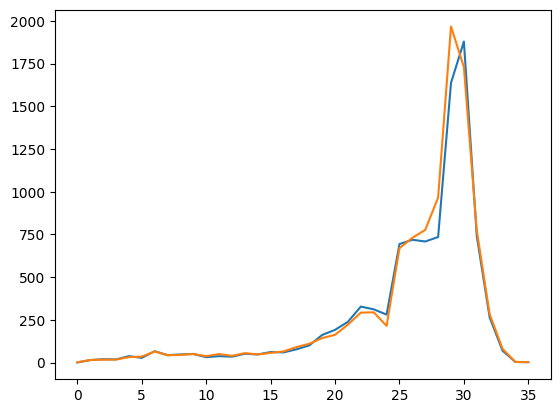

In [21]:
model.eval()
plt.plot(true_y[0,0,:,0])
predicted_y = model(pred_x_time.to("cuda"), pred_x_event.to('cuda'), edge_index)
plt.plot(predicted_y[0,0,:,0].cpu().detach().numpy())

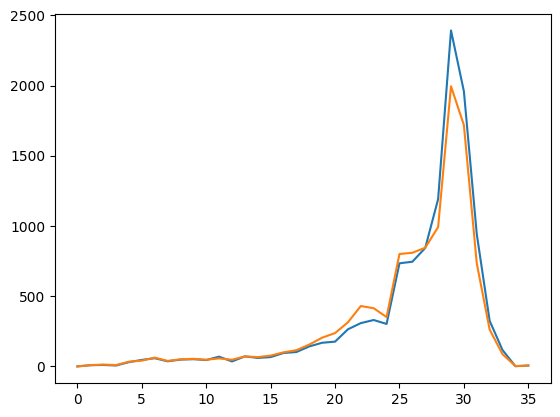

In [22]:
plt.plot(STGCNY[1,0,:,0])
predicted_y = model(STGCNX[:, :, :, :-1].to("cuda"), STGCNX[:, :, :, -1:].to("cuda"), edge_index)
plt.plot(predicted_y[1,0,:,0].cpu().detach().numpy())

In [23]:
停止

NameError: name '停止' is not defined

In [ ]:
STGCNX.shape

 # 模型使用

In [38]:
model.eval()  # 切换到评估模式
x_test = STGCNX_test.to("cuda")
x_test_time = x_test[:, :, :, :-1].to("cuda")
x_test_event = x_test[:, :, :, -1:].to("cuda")
in_flow = model(x_test_time,x_test_event, edge_index.to("cuda"))
torch.save(in_flow.permute(1,0,2,3)[station_mask].permute(1,0,2,3), 'in_flow.pt')#4天，150个站点,48个时间点，8个特征

In [ ]:
STGCNY.shape

In [ ]:
# sta_info_for_adj['station_name'] = pd.Categorical(sta_info_for_adj['station_name'], categories=categories_list, ordered=True)
# sta_info_for_adj = sta_info_for_adj.sort_values(["abs_date",'station_name','time_point'])
# (torch.tensor(sta_info_for_adj['in_flow'],dtype=torch.float)==STGCNY.permute(1,0,2,3).permute(1,0,2,3).flatten()).all()

In [39]:
test_set['station_name'] = pd.Categorical(test_set['station_name'], categories=categories_list, ordered=True)
test_set = test_set.sort_values(["abs_date",'station_name','time_point'])
test_set_in_flow = in_flow

In [41]:
test_set.to_csv('test_set_inflow.csv')

In [ ]:
test_set['abs_date'].unique()

In [ ]:
# 咳咳
# 停下
STGCNX.shape

In [ ]:
[[],[]]

## 训练GCN（效果不佳）

In [ ]:

# prepare model parameters
num_features = 4
num_classes = 2
model = models.GCN(num_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


In [ ]:
model

In [ ]:
# start training
import random
duptimes = 50 # 每个数据输入进模型训练的次数
total_input_sz = len(data_input)
# random.shuffle(data_input)
test_set_sz = 48 # 预测集大小
train_set_sz = total_input_sz - test_set_sz
model.train()
for dup_i in range(duptimes):
    optimizer.zero_grad()  # 清除梯度
    loss1,loss2=0.0,0.0
    for epoch in range(train_set_sz):
        out_y = model(data_input[epoch])  # 前向传播
        out_y1_for_loss = out_y[:, 0][station_mask]
        out_y2_for_loss = out_y[:, 1][station_mask]
        true_y1_for_loss = data_input[epoch].y[:, 0][station_mask]
        true_y2_for_loss = data_input[epoch].y[:, 1][station_mask]
        loss1 += criterion(out_y1_for_loss, true_y1_for_loss)  # 计算损失
        loss2 += criterion(out_y2_for_loss, true_y2_for_loss)
    loss = loss1+loss2  # 加权求和
    if dup_i % (duptimes / 20) == 0:
        print('dup_i=', dup_i, '\t\tloss=', loss1.item(),loss2.item())
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数



In [ ]:
data_input[epoch].y[:, 1]

## 预测

In [ ]:
# make prediction
model.eval()
predict_data: List[Data] = data_input[:train_set_sz]

predict_in_flow = []
predict_out_flow = []
for piece in predict_data:
    pre_out = model(piece)
    pre_out = abnorm_min_max(pre_out.detach(), min_y, max_y)
    predict_in_flow.append(pre_out[:, 0][station_mask])
    predict_out_flow.append(pre_out[:, 1][station_mask])

In [ ]:
piece.x

## 验证效果

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 将预测值和真实值转换为 numpy 数组以便使用 sklearn 库计算评估指标
true_in_flow = np.array([data.y[:, 0][station_mask].detach().numpy() for data in predict_data])
true_out_flow = np.array([data.y[:, 1][station_mask].detach().numpy() for data in predict_data])
predicted_in_flow = np.array([out.detach().numpy() for out in predict_in_flow])
predicted_out_flow = np.array([out.detach().numpy() for out in predict_out_flow])

# 计算 MAE 和 RMSE
true_in_flow = abnorm_min_max(true_in_flow,min_y[0],max_y[0])
true_out_flow = abnorm_min_max(true_out_flow,min_y[1],max_y[1])
mae_in = mean_absolute_error(true_in_flow, predicted_in_flow)
rmse_in = np.sqrt(mean_squared_error(true_in_flow, predicted_in_flow))

mae_out = mean_absolute_error(true_out_flow, predicted_out_flow)
rmse_out = np.sqrt(mean_squared_error(true_out_flow, predicted_out_flow))

print(f"MAE for In-Flow: {mae_in}, RMSE for In-Flow: {rmse_in}")
print(f"MAE for Out-Flow: {mae_out}, RMSE for Out-Flow: {rmse_out}")

In [ ]:
# plt.plot(true_in_flow[:,-3])
plt.plot(predicted_in_flow[:,-3])
plt.plot(predicted_in_flow[:,-45])

In [ ]:
abs(np.array(torch.tensor(np.array(ori_y)[-48:]).permute(1,0,2)[station_mask][:,:,0].permute(1,0))-predicted_in_flow).mean()

In [ ]:
plt.plot(predicted_in_flow[:48,-0])
# plt.plot(predicted_in_flow[:,-1])
# plt.plot(predicted_in_flow[:,-2])
# plt.plot(predicted_in_flow[:,-3])